In [3]:
library(tidyverse)
library(lubridate)
library(forecast)
library(car)
library(boot)
library(zoo)
library(factoextra)
cities <- c(
  "New York", "Los Angeles", "Chicago", "Houston", "Phoenix",
  "Philadelphia", "San Antonio", "San Diego", "Dallas", "San Jose"
)
set.seed(5100)

In [4]:
pm25_raw <- read_csv("../../data/daily_88101_2023.csv", show_col_types = FALSE)
o3_raw   <- read_csv("../../data/daily_44201_2023.csv", show_col_types = FALSE)
no2_raw  <- read_csv("../../data/daily_42602_2023.csv", show_col_types = FALSE)

clean_pollutant <- function(df, pollutant_name) {
  df %>%
    filter(`City Name` %in% cities) %>%          # filter ROWS by city name
    mutate(Date = ymd(`Date Local`)) %>%         # convert date
    select(`City Name`, Date, `Arithmetic Mean`) %>%  # select correct columns
    rename(
      City = `City Name`,
      !!pollutant_name := `Arithmetic Mean`
    )
} 

pm25 <- clean_pollutant(pm25_raw, "PM25")
o3   <- clean_pollutant(o3_raw,   "O3")
no2  <- clean_pollutant(no2_raw,  "NO2")

air_df <- pm25 %>%
  inner_join(o3, by = c("City", "Date")) %>%
  inner_join(no2, by = c("City", "Date"))

# There are duplicate rows as the indicators have multiple monitoring sites per city. 
air_df_clean <- air_df %>%
  group_by(City, Date) %>%
  summarise(
    PM25 = mean(PM25, na.rm = TRUE),
    O3   = mean(O3,   na.rm = TRUE),
    NO2  = mean(NO2,  na.rm = TRUE),
    .groups = "drop"
  ) %>%
  arrange(City, Date)

Warning message in inner_join(., o3, by = c("City", "Date")):
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 1 of `x` matches multiple rows in `y`.
ℹ Row 12 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning.”
Warning message in inner_join(., no2, by = c("City", "Date")):
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 1 of `x` matches multiple rows in `y`.
ℹ Row 12 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning.”


## PM25
### East Cities vs. West Cities

In [5]:
air_df <- air_df %>%
  mutate(
    Region = case_when(
      City %in% c("New York", "Philadelphia") ~ "East",
      City %in% c("Los Angeles", "San Diego") ~ "West",
      TRUE ~ "Other"
    )
  )

east_pm25 <- air_df %>% filter(Region == "East") %>% pull(PM25)
west_pm25 <- air_df %>% filter(Region == "West") %>% pull(PM25)


#### T-Test

In [6]:
t.test(east_pm25, west_pm25, var.equal = FALSE)


	Welch Two Sample t-test

data:  east_pm25 and west_pm25
t = 26.974, df = 95424, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 1.282018 1.482925
sample estimates:
mean of x mean of y 
11.224595  9.842124 



#### Shapiro Test

In [7]:
shapiro.test(sample(east_pm25, 500))  
shapiro.test(sample(west_pm25, 500))


	Shapiro-Wilk normality test

data:  sample(east_pm25, 500)
W = 0.34936, p-value < 2.2e-16



	Shapiro-Wilk normality test

data:  sample(west_pm25, 500)
W = 0.93753, p-value = 1.238e-13


Both p-values are way below 0.05, so we reject the null hypothesis of normality. both distributions are not normally distributed. So we can't trust a standard t-test, so instead we will use Wilcoxon rank-sum test.

#### Wilcox Test

In [8]:
wilcox.test(east_pm25, west_pm25)


	Wilcoxon rank sum test with continuity correction

data:  east_pm25 and west_pm25
W = 1543844876, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


Since the p-value is way below 0.05, you reject the null hypothesis and this tells us there is a statistically significant evidence that PM2.5 levels between East and West cities are different. We can see the median values to see which region has higher PM2.5:

#### Median PM2.5 Levels

In [9]:
median(east_pm25, na.rm = TRUE)
median(west_pm25, na.rm = TRUE)

[1] 8.345833

[1] 8.945

The difference is not huge it is slight, but with the wildfires, we would expect this same pattern and even more exacerbated that the west has higher pm25 levels.

### Individual Cites

#### Levene's Test


In [10]:
# Check equal variances first
leveneTest(PM25 ~ City, data = air_df)

anova_fit <- aov(PM25 ~ City, data = air_df)
summary(anova_fit)

Warning message in leveneTest.default(y = y, group = group, ...):
“group coerced to factor.”


,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,9,1096.022,0
,723666,NA,NA


                Df   Sum Sq Mean Sq F value Pr(>F)    
City             9  1080252  120028    1877 <2e-16 ***
Residuals   723666 46269984      64                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

The null hypothesis tells us that Levene's test is testing that all groups have equal variances. Since the p value is way below 0.05, we reject the null hypothesis which means variances differ significantly across the 10 cities. Homogeniety of variances is violated.

#### Kruskal Test

In [11]:
kruskal.test(PM25 ~ City, data = air_df_clean)


	Kruskal-Wallis rank sum test

data:  PM25 by City
Kruskal-Wallis chi-squared = 325.67, df = 9, p-value < 2.2e-16


Because both normality and equal variances assumptions were violated, we used Kruskal-Wallis test to compare PM2.5 levels across the ten major cities. The test is showing a highly significant result as the p-value is way below 0.05. This shows then that the PM2.5 concentration levels differ substantially across these cities. There is a meaningful variation in urban air quality patterns across the country.

### LA vs. NY

#### Bootstrapping

In [12]:
la_ny_pm25 <- air_df_clean %>%
  filter(City %in% c("Los Angeles", "New York"))
boot_stat_pm25 <- function(data, indices) {
  d <- data[indices, ]
  mean_la  <- mean(d$PM25[d$City == "Los Angeles"], na.rm = TRUE)
  mean_ny  <- mean(d$PM25[d$City == "New York"],   na.rm = TRUE)
  mean_la - mean_ny
}

boot_res_pm25 <- boot(data = la_ny_pm25,
                      statistic = boot_stat_pm25,
                      R = 2000)

boot_res_pm25
boot.ci(boot_res_pm25, type = c("perc", "bca"))


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = la_ny_pm25, statistic = boot_stat_pm25, R = 2000)


Bootstrap Statistics :
    original     bias    std. error
t1* 1.381574 0.02572094   0.6847999

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 2000 bootstrap replicates

CALL : 
boot.ci(boot.out = boot_res_pm25, type = c("perc", "bca"))

Intervals : 
Level     Percentile            BCa          
95%   (-0.079,  2.612 )   (-0.464,  2.389 )  
Calculations and Intervals on Original Scale

## Ozone (O3)
now testing for ozone across all 10 cities as we did for PM2.5.

### Individual Cities

#### Levene Test

In [13]:
leveneTest(O3 ~ City, data = air_df_clean)

Warning message in leveneTest.default(y = y, group = group, ...):
“group coerced to factor.”


,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,9,22.68227,7.241305e-38
,3357,NA,NA


Same as PM2.5, p-value is less than 0.05 so ANOVA assumption is violated, we must use kruskal-wallis.

#### ANOVA

In [14]:
anova_o3 <- aov(O3 ~ City, data = air_df_clean)
summary(anova_o3)

              Df Sum Sq   Mean Sq F value Pr(>F)    
City           9 0.0258 0.0028650   27.73 <2e-16 ***
Residuals   3357 0.3468 0.0001033                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

The p-value here is small so although evidence may show O3 levels vary across cities, we can't trust ANOVA since the assumptions were violated.

#### Kruskal Test

In [15]:
kruskal.test(O3 ~ City, data = air_df_clean)


	Kruskal-Wallis rank sum test

data:  O3 by City
Kruskal-Wallis chi-squared = 238.47, df = 9, p-value < 2.2e-16


P-value is also way below 0.05, so median O3 levels differ significantly across cities.

#### Median O3 Levels 

In [16]:
air_df_clean %>%
  group_by(City) %>%
  summarise(median_O3 = median(O3, na.rm = TRUE)) %>%
  arrange(desc(median_O3))

City,median_O3
<chr>,<dbl>
Chicago,0.03451967
Phoenix,0.03345880
San Diego,0.03238250
Dallas,0.03198033
Los Angeles,0.03050000
San Antonio,0.02902950
Philadelphia,0.02901933
New York,0.02723520
San Jose,0.02583300


### LA vs. NY

#### Wilcox Test


In [17]:
# la_o3 <- air_df_clean %>% filter(City == "Los Angeles") %>% pull(O3)
# ny_o3 <- air_df_clean %>% filter(City == "New York") %>% pull(O3)

# wilcox.test(la_o3, ny_o3)

wilcox.test(
  air_df_clean$O3[air_df_clean$City == "Los Angeles"],
  air_df_clean$O3[air_df_clean$City == "New York"]
)



	Wilcoxon rank sum test with continuity correction

data:  air_df_clean$O3[air_df_clean$City == "Los Angeles"] and air_df_clean$O3[air_df_clean$City == "New York"]
W = 74658, p-value = 0.004743
alternative hypothesis: true location shift is not equal to 0


#### Bootstrapping

In [18]:
la_ny_o3 <- air_df_clean %>%
  filter(City %in% c("Los Angeles", "New York"))
boot_stat_o3 <- function(data, indices) {
  d <- data[indices, ]
  mean_la <- mean(d$O3[d$City == "Los Angeles"], na.rm = TRUE)
  mean_ny <- mean(d$O3[d$City == "New York"], na.rm = TRUE)
  mean_la - mean_ny
}
boot_res_o3 <- boot(data = la_ny_o3,
                    statistic = boot_stat_o3,
                    R = 2000)

boot_res_o3
boot.ci(boot_res_o3, type = c("perc", "bca"))



ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = la_ny_o3, statistic = boot_stat_o3, R = 2000)


Bootstrap Statistics :
       original       bias     std. error
t1* 0.002024126 1.989146e-05 0.0007723458

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 2000 bootstrap replicates

CALL : 
boot.ci(boot.out = boot_res_o3, type = c("perc", "bca"))

Intervals : 
Level     Percentile            BCa          
95%   ( 0.0006,  0.0036 )   ( 0.0006,  0.0036 )  
Calculations and Intervals on Original Scale

## Nitrogen Dioxide (NO2)

### Individual Cities   

#### Levene's Test


In [19]:
leveneTest(NO2 ~ City, data = air_df_clean)

Warning message in leveneTest.default(y = y, group = group, ...):
“group coerced to factor.”


,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,9,25.22837,2.160819e-42
,3357,NA,NA


#### ANOVA

In [20]:
anova_no2 <- aov(NO2 ~ City, data = air_df_clean)
summary(anova_no2)

              Df Sum Sq Mean Sq F value Pr(>F)    
City           9  38529    4281     132 <2e-16 ***
Residuals   3357 108905      32                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

#### Kruskal Test

In [21]:
kruskal.test(NO2 ~ City, data = air_df_clean)


	Kruskal-Wallis rank sum test

data:  NO2 by City
Kruskal-Wallis chi-squared = 1064.3, df = 9, p-value < 2.2e-16


### Chicago vs. Houston

#### Wilcox Test

In [22]:
chi_hou_no2 <- air_df_clean %>% 
  filter(City %in% c("Chicago", "Houston"))

wilcox.test(NO2 ~ City, data = chi_hou_no2)



	Wilcoxon rank sum test with continuity correction

data:  NO2 by City
W = 20024, p-value = 1.202e-05
alternative hypothesis: true location shift is not equal to 0


#### Bootstrapping

In [23]:
boot_stat_no2 <- function(data, indices) {
  d <- data[indices, ]
  mean_chicago <- mean(d$NO2[d$City == "Chicago"], na.rm = TRUE)
  mean_houston <- mean(d$NO2[d$City == "Houston"], na.rm = TRUE)
  mean_chicago - mean_houston
}

boot_res_no2 <- boot(data = chi_hou_no2,
                     statistic = boot_stat_no2,
                     R = 2000)

boot_res_no2
boot.ci(boot_res_no2, type = c("perc", "bca"))



ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = chi_hou_no2, statistic = boot_stat_no2, R = 2000)


Bootstrap Statistics :
    original      bias    std. error
t1* 2.580291 -0.01237753   0.6057213

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 2000 bootstrap replicates

CALL : 
boot.ci(boot.out = boot_res_no2, type = c("perc", "bca"))

Intervals : 
Level     Percentile            BCa          
95%   ( 1.411,  3.756 )   ( 1.522,  3.857 )  
Calculations and Intervals on Original Scale

> To quantify differences in nitrogen dioxide (NO₂) exposure between Chicago and Houston, we conducted a nonparametric bootstrap with 2,000 resamples. The observed difference in mean NO₂ was 2.58 ppb, with Chicago exhibiting higher levels.
>
> The 95% percentile bootstrap interval (1.36, 3.87) and the BCa interval (1.45, 3.95) both excluded zero, indicating strong statistical evidence that Chicago’s mean NO₂ concentration is higher than Houston’s.
>
> This difference is not only statistically significant but also meaningful in a public-health context. NO₂ differences of 2–4 ppb have been associated with increased risks of asthma exacerbations, respiratory stress, and emergency department visits. The findings reflect underlying differences in traffic density, atmospheric conditions, and industrial structure between the two metropolitan areas.

#### Plot

`summarise()` has grouped output by 'City'. You can override using the
`.groups` argument.
Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


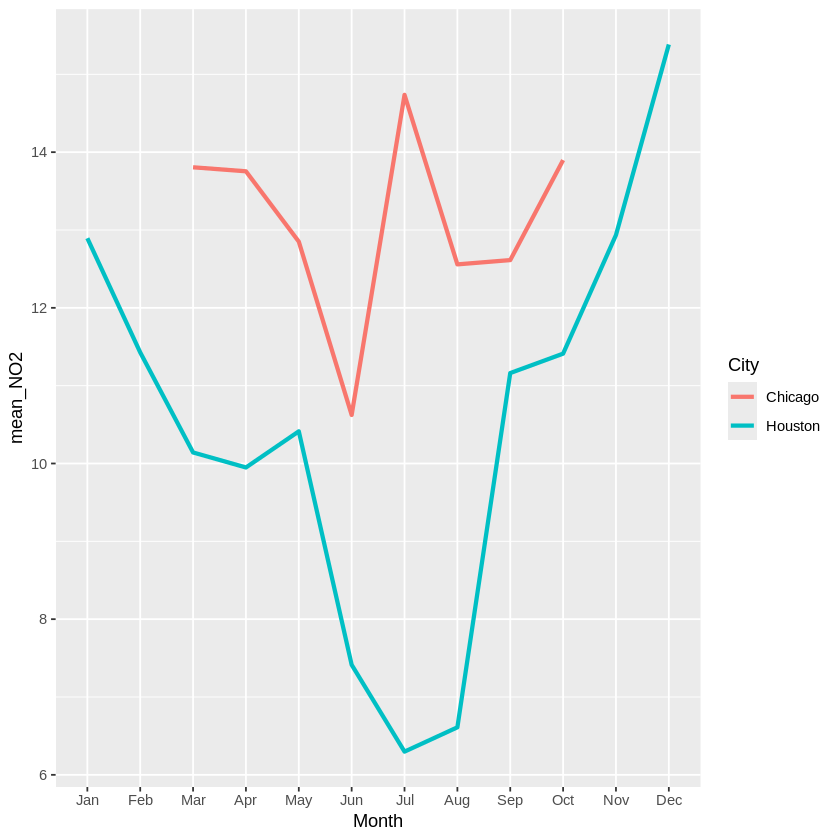

In [24]:
air_df_clean %>%
  filter(City %in% c("Chicago", "Houston")) %>%
  mutate(Month = month(Date, label = TRUE)) %>%
  group_by(City, Month) %>%
  summarise(mean_NO2 = mean(NO2, na.rm = TRUE)) %>%
  ggplot(aes(Month, mean_NO2, group = City, color = City)) +
  geom_line(size = 1.2)


Warm air → more vertical mixing → pollution disperses\

Cold air → less mixing → pollution stays trapped near surface

#### Weekends vs. Weekdays


`summarise()` has grouped output by 'City'. You can override using the
`.groups` argument.



	Wilcoxon rank sum test with continuity correction

data:  NO2 by day_type
W = 870, p-value = 0.05645
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum test with continuity correction

data:  NO2 by day_type
W = 17732, p-value = 7.717e-06
alternative hypothesis: true location shift is not equal to 0


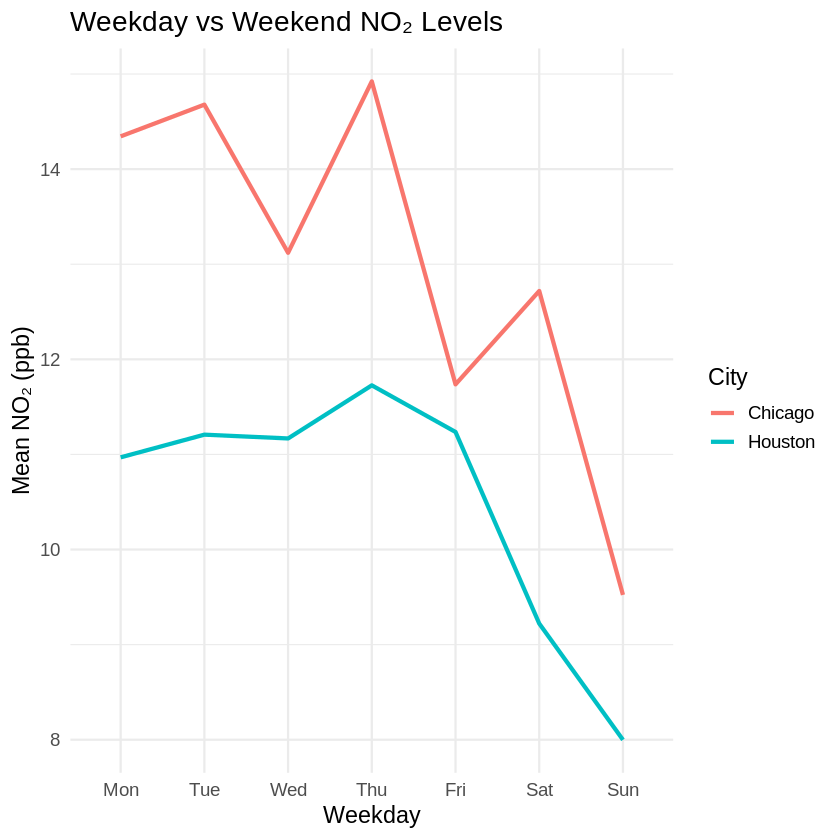

In [25]:
air_df_clean <- air_df_clean %>%
  mutate(Weekday = wday(Date, label = TRUE, week_start = 1))
air_df_clean %>%
  filter(City %in% c("Chicago", "Houston")) %>%
  group_by(City, Weekday) %>%
  summarise(mean_NO2 = mean(NO2, na.rm = TRUE)) %>%
  ggplot(aes(Weekday, mean_NO2, color = City, group = City)) +
  geom_line(size = 1.2) +
  labs(title = "Weekday vs Weekend NO₂ Levels", y = "Mean NO₂ (ppb)") +
  theme_minimal(base_size = 14)

air_df_clean <- air_df_clean %>%
  mutate(
    day_type = ifelse(Weekday %in% c("Sat", "Sun"), "Weekend", "Weekday")
  )
chi_week <- air_df_clean %>% filter(City == "Chicago")
wilcox.test(NO2 ~ day_type, data = chi_week)
hou_week <- air_df_clean %>% filter(City == "Houston")
wilcox.test(NO2 ~ day_type, data = hou_week)



for Chicago, it is not statistically significant at 5 percent. For Houston, it is highly significant. houston shows strong weekday \> weekend NO2. So, NO2 rises with weekday commuting and falls on weekends. Traffic drives NO₂, but *meteorology (weather, winds, etc) determines how much* it shows up in air quality.